In [1]:
import numpy as np
import os
import scipy 
from sympy import *
import pylab as plt
import math
import matplotlib.image as mpimg
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, spherical_yn
#from pdf2image import convert_from_path
%matplotlib inline

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

BohrInAng = .529177210544
uBohrInAng = .00000000082

HartreeInEV = 27.211386245981
uHartreeInEV = .00000000030

hcInEVAngstrom = 1973.2698044

In [3]:
def Silvera_Triplet(R):
    x = R * hcInEVAngstrom / 4.16 
    D = 1.28
    K2eV = 8.617333262e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

def pucSilvera_Triplet(R):
    x = R * hcInEVAngstrom / 4.16 
    return Silvera_Triplet(R)*(1 + .1*x)

def nucSilvera_Triplet(R):
    x = R * hcInEVAngstrom / 4.16 
    return Silvera_Triplet(R)*(1 + -.1*x)


def Triplet(x): 
    conv = hcInEVAngstrom / BohrInAng
    R = x * conv
    P = np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    return P * HartreeInEV

def J(Rho):
    R = Rho * hcInEVAngstrom / BohrInAng
    P = np.exp(-.288-.275*R-.176*R**2+.0068*R**3)
    return P * HartreeInEV

def Singlet(R):
    return Silvera_Triplet(R) - J(R)

In [4]:
data = np.genfromtxt('/Users/tikitorch/Desktop/shortrangesinglet.csv', delimiter=',', skip_header=1)
data2 = np.genfromtxt('/Users/tikitorch/Desktop/NewerKolos.csv', delimiter=',', skip_header=1)

interp_func = interp1d(data[:,0], data[:,1], kind = 'cubic',fill_value='extrapolate')
interp_funcnew = interp1d(data2[:,0], -data2[:,1], kind = 'cubic',fill_value='extrapolate')

ranges = data[:,0]
singlet_data = data[:,1]

def singlet(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_func(Rp) + 1) * HartreeInEV

new_ranges = np.linspace(.45, 10, 100) / hcInEVAngstrom

def singletnew(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_funcnew(Rp) + 1) * HartreeInEV

def singletcombo(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    split1_2=6.3 # Make the split within the range where function has support (between last 2 bins)
    split2_3=11.5 #  [As above]
    Decide1=(Rp<split1_2)
    Decide2=(Rp>=split1_2)*(Rp<split2_3)
    Decide3=(Rp>=split2_3)

    #return (Decide1*(interp_func(R * 1973) + 1)  + Decide2*(interp_funcnew(R * 1973) + 1) + Decide3*(interp_funcnew(10) + 1)*(R*1973.27/10)**-6) * 27.2114

    return (Decide1*(interp_func(Rp) + 1)  + Decide2*(interp_funcnew(Rp) + 1) + Decide3*(interp_funcnew(split2_3) + 1)*(Rp/split2_3)**-6) * HartreeInEV

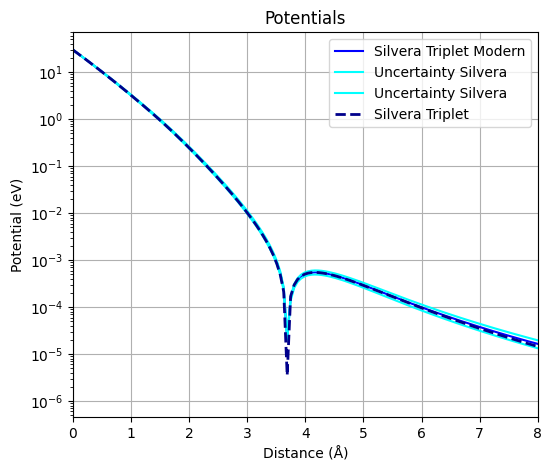

In [49]:
a = .006
rhos = np.linspace(1e-9, a, 200)
plt.figure(figsize=(6, 5))
plt.plot(rhos*hcInEVAngstrom,np.abs(Silvera_Triplet(rhos)), label="Silvera Triplet Modern", color='Blue')
plt.plot(rhos*hcInEVAngstrom,np.abs(nucSilvera_Triplet(rhos)), label="Uncertainty Silvera", color='Cyan')
plt.plot(rhos*hcInEVAngstrom,np.abs(pucSilvera_Triplet(rhos)), label="Uncertainty Silvera", color='Cyan')
plt.plot(rhos*hcInEVAngstrom,np.abs(Triplet(rhos)), '--', label="Silvera Triplet", color ='DarkBlue', linewidth=2)
#plt.plot(rhos*hcInEVAngstrom,np.abs(Singlet(rhos)), label="Silvera Singlet", color='DarkGreen')
#plt.plot(rhos*hcInEVAngstrom,np.abs(singlet(rhos)), label="Kolos Singlet", color='DarkRed')
#plt.plot(rhos*hcInEVAngstrom,np.abs(singletcombo(rhos)), label="Kolos Wolniewicz Singlet", color='black')
plt.semilogy()
plt.xlabel("Distance (Å)") 
plt.xlim(0,8)
plt.ylabel("Potential (eV)") 
#plt.ylim(-6,10)
plt.title("Potentials")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def p_of_temp(mu, T):
    J2eV = 6.241508074e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mu):
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

def p_abs(mu, pin, epsa, epsb, epsprimea, epsprimeb):
    psquared = pin**2 + mu * (epsa + epsb - epsprimea - epsprimeb)
    return np.sqrt(psquared)

In [7]:
def ddx(y, rho, mu, Potential, l, pin):
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]

def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0], rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return (np.sqrt(2/np.pi)*State.y[0]/Normalization[-1],np.sqrt(2/np.pi)*State.y[1]/Normalization[-1])

def GetPhaseShift(bigrho, p, l, r0, mass, version, how_to_int):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    
    State = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[0])
    Statedev = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[1])

    Big = Big_delta_l = (rhos * Statedev - State) / (rhos * State)
    jl_ka = spherical_jn(l, p * rhos)
    jl_prime_ka = spherical_jn(l, p * rhos, derivative=True)
    nl_ka = spherical_yn(l, p * rhos)
    nl_prime_ka = spherical_yn(l, p * rhos, derivative=True)

    #deltas = np.arctan((p*jl_prime_ka - Big_delta_l*jl_ka) / (p*nl_prime_ka - Big_delta_l * nl_ka)) 
    deltas=np.arctan(p*State/Statedev)-p*rhos
    return deltas[-1]

def GetSpatials(mu, B, levels, version_one, version_two):
    aaSpatials = []
    acSpatials = []
    bdSpatials = []
    i = 0
    for bs in B:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        temp = 5e-6
        intlimit = 10 * BohrInAng/hcInEVAngstrom #When running with Kolos potential use 10 * when using Silvera potential use 20*

        Pin = p_of_temp(mu, temp)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, c, a, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        const = np.pi / (mu * Pin)
        
        tdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_two, 'Radau')

        aaSpatials.append(11.6 * const * (Pin * Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
        acSpatials.append(11.6 * const * (Pin * Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
        bdSpatials.append(11.6 * const * (Pin * Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))

        i = i + 1

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    bdSpatials = np.array(bdSpatials)

    return(aaSpatials, acSpatials, bdSpatials)

In [8]:
B_Values = np.logspace(-3,1,100)
B_Naught = 1 + B_Values/3.17e-3

In [9]:
def GetHyperFineLevels(pm, mf, delW, mN, gI, ge, meeV, mue):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.241509074e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI, ge, meeV, mue): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI, ge, meeV, mue))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [10]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
udelWH = .0000000000010e9
delWT = 1.516701470775e9
udelWT = .0000000000007e9

gIH = 5.585694706 # Hydrogen nuclear g-factor
ugIH = .000000056
gIT = 5.957924930 
ugIT = .000000012
mH = 1.00727646657894 #Mass of hydrogen in Dalton
umH = .0000000000083
mT = 3.01550071597 
umT = .00000000010

ge = 2.00231930436092
uge = .00000000000036
meeV = .51099895069e6
umeeV = .00000000016e6
mue = 9.2847646917e-24
umue = .0000000029e-24

HLevels = AllHFLevels(delWH, mH, gIH, ge, meeV, mue)
TLevels = AllHFLevels(delWT, mT, gIT, ge, meeV, mue)

In [11]:
lets = ['a', 'b', 'c', 'd']
ucHLevels = {let: [] for let in lets}
for let in lets:
    i = 0
    for bs in B_Values:
        cudelWH = 1/2 * (AllHFLevels(delWH + udelWH/np.sqrt(12), mH, gIH, ge, meeV, mue)[let][i] - AllHFLevels(delWH - udelWH/np.sqrt(12), mH, gIH, ge, meeV, mue)[let][i])
        cumH = 1/2 * (AllHFLevels(delWH, mH + umH/np.sqrt(12), gIH, ge, meeV, mue)[let][i] - AllHFLevels(delWH, mH - umH/np.sqrt(12), gIH, ge, meeV, mue)[let][i])
        cugIH = 1/2 * (AllHFLevels(delWH, mH, gIH + ugIH/np.sqrt(12), ge, meeV, mue)[let][i] - AllHFLevels(delWH, mH, gIH - ugIH/np.sqrt(12), ge, meeV, mue)[let][i])
        cuge = 1/2 * (AllHFLevels(delWH, mH, gIH, ge + uge/np.sqrt(12), meeV, mue)[let][i] - AllHFLevels(delWH, mH, gIH, ge - uge/np.sqrt(12), meeV, mue)[let][i])
        cumeeV = 1/2 * (AllHFLevels(delWH, mH, gIH, ge, meeV + umeeV/np.sqrt(12), mue)[let][i] - AllHFLevels(delWH, mH, gIH, ge, meeV - umeeV/np.sqrt(12), mue)[let][i])
        cumue = 1/2 * (AllHFLevels(delWH, mH, gIH, ge, meeV, mue + umue/np.sqrt(12))[let][i] - AllHFLevels(delWH, mH, gIH, ge, meeV, mue - umue/np.sqrt(12))[let][i])

        uc = np.sqrt(cudelWH**2 + cumH**2 + cugIH**2 + cuge**2 + cumeeV**2  + cumue**2)
        ucHLevels[let].append(uc)
        i = i + 1

In [12]:
meeV = .51099895069e6
Hm = 938.27208942e6 + meeV #Mass of hydrogen in eV/c^2
uHm = np.sqrt(.00000029e6**2 + umeeV**2)
Tm = 2808.92113668e6 + meeV
Hmu = Hm/2
uHmu = uHm/2
Tmu = Tm/2

gamH=42.56385437*1e6 # In Hz T^-1
gamT=45.41483817*1e6 # In Hz T^-1

In [13]:
e=symbols('e')
c=symbols('c')
s=symbols('s')
sr2=symbols('sr2')
sr3=symbols('sr3')

In [14]:
def LetterToNumber(letter):
    if(letter=="a"):
        return 0
    elif(letter=="b"):
        return 1
    elif(letter=="c"):
        return 2
    elif(letter=="d"):
        return 3
    else:
        print("invalid letter state, "+str(letter))
        assert(0)

In [15]:
def NumberToLetter(num):
    if(num==0):
        return "a"
    elif(num==1):
        return "b"
    elif(num==2):
        return "c"
    elif(num==3):
        return "d"
    else:
        print("invalid number state, "+str(num))
        assert(0)

In [16]:
def StateToBasis(in1,in2,p=1):
    # convert letter basis to number basis
    if(type(in1)==str):
        in1=LetterToNumber(in1)
    else:
        in1=int(in1)
    if(type(in2)==str):
        in2=LetterToNumber(in2)
    else:
        in2=int(in2)
    #swap so first one is always smaller
    if(in2<in1):
        in1old=in1
        in1=in2
        in2=in1old

    if(in1==0 and in2==0 and p==1):
        return 0
    if(in1==1 and in2==1 and p==1):
        return 1
    if(in1==2 and in2==2 and p==1):
        return 2
    if(in1==3 and in2==3 and p==1):
        return 3
    if(in1==0 and in2==1 and p==1):
        return 4
    if(in1==0 and in2==1 and p==-1):
        return 5
    if(in1==0 and in2==2 and p==1):
        return 6
    if(in1==0 and in2==2 and p==-1):
        return 7
    if(in1==0 and in2==3 and p==1):
        return 8
    if(in1==0 and in2==3 and p==-1):
        return 9
    if(in1==1 and in2==2 and p==1):
        return 10
    if(in1==1 and in2==2 and p==-1):
        return 11
    if(in1==1 and in2==3 and p==1):
        return 12
    if(in1==1 and in2==3 and p==-1):
        return 13
    if(in1==2 and in2==3 and p==1):
        return 14
    if(in1==2 and in2==3 and p==-1):
        return 15

In [17]:
SingletProj=np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

TripletProj=np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0,  0.5,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ])

In [18]:
Rotator=[
    [1,  0,  0,  0,  0,  0, 2*e, 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0, -2*e,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -e,  0,  0,  0,  0],
    [-e, 0,  e,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, -e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1]
                ]

    # aa      bb    cc  dd     ab ab  ac     ac  ad  ad  bc  bc  bd  bd  cd  cd 
Rotator=np.array([
    [c*c,     0,    s*s,0,     0,  0,sr2*s*c, 0,  0,  0,  0,  0,  0,  0,  0,  0],   #aa
    [0,       1,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #bb
    [s*s,     0,    c*c,0,     0,  0,-sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],   #cc
    [0,       0,    0,  1,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #dd
    [0,       0,    0,  0,     c,  0,  0,     0,  0,  0,  s,  0,  0,  0,  0,  0],   #ab
    [0,       0,    0,  0,     0,  c,  0,     0,  0,  0,  0,  s,  0,  0,  0,  0],   #ab
    [-sr2*s*c,0,sr2*s*c,0,     0,  0, c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0,  0],   #ac  
    [0,       0,    0,  0,     0,  0,  0,     1,  0,  0,  0,  0,  0,  0,  0,  0],   #ac
    [0,       0,    0,  0,     0,  0,  0,     0,  c,  0,  0,  0,  0,  0,  s,  0],   #ad
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  c,  0,  0,  0,  0,  0,  s],   #ad
    [0,       0,    0,  0,    -s,  0,  0,     0,  0,  0,  c,  0,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  -s, 0,     0,  0,  0,  0,  c,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  1,  0,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  1,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  -s, 0,  0,  0,  0,  0,  c,  0],   #cd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  -s, 0,  0,  0,  0,  0,  c]    #cd
                        ])

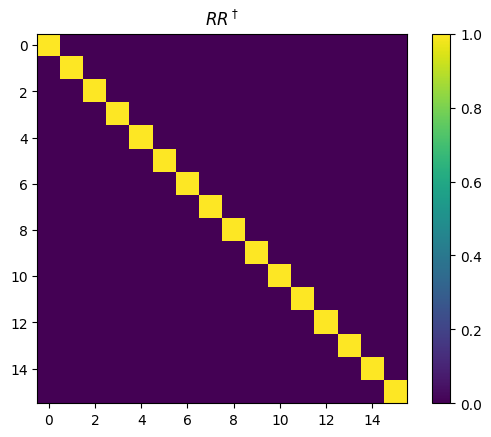

In [19]:
#Check unitarity of rotator matrix

Mat=np.matmul(Rotator,np.transpose(Rotator))
th=0.3
ar=[]
for i in Mat:
    linear=[]
    for j in i:
        if(type(j)!=int):
            linear.append(float(j.subs(sr2,np.sqrt(2)).subs(sr3,np.sqrt(3)).subs(c,np.cos(th)).subs(s,np.sin(th))))
        else:
            linear.append(float(j))
    ar.append(linear)
plt.imshow(ar)
plt.title(r"$R R^\dagger$")
plt.colorbar()

In [20]:
def TransformMatrix(M,R):
    return(np.matmul(np.transpose(R),np.matmul(M,R)))

def RotateByEpsilon(M,eps):
    M1=TransformMatrix(M,Rotator)
    return(EvaluateWithEpsilon(M,eps))

def EvaluateWithEpsilon(M,eps):
    return np.array([(i+0*e).subs(e,eps) for i in M.flatten()]).reshape(M.shape).astype(float)

In [21]:
def GetElement(M,alpha, beta, p1, alphaprime, betaprime, pprime):
    index1=StateToBasis(alpha,beta,p1)
    index2=StateToBasis(alphaprime,betaprime,pprime)
    return(M[index1,index2])

In [22]:
# The notation in Stoof is difficult, and he isnt clear about the values.
# Silvera and Walraven P157 makes it clearer what numbers to use.
muN = 5.0507837393e-27
umuN = .0000000016e-27
mue = 9.2847646917e-24
umue = .0000000029e-24


magH = gIH * muN  
umagH = np.sqrt(ugIH**2 + umuN**2)
magT = gIT * muN   
umagT = np.sqrt(ugIT**2 + umuN**2)
mage = ge * mue  
umage = np.sqrt(uge**2 + umue**2)

hbar =6.62607015e-34
aH= delWH * hbar
aT= delWT * hbar

def Theta(a, B, magN):
    muplus=mage + magN  # In notation of Silvera and Walraven
    return (0.5*np.arctan(a / (B * muplus))) #has large B limit -> a/ (2 muplus B) as reqd
print(aH, aT)

9.411708152669641e-25 1.0049770341963325e-24


In [23]:
def Getspin(a, B_values, magN, a3, a4):
    line = []
    for Bs in B_values:
        th = Theta(a, Bs,magN )
        
        SpinPart = TransformMatrix(TripletProj-SingletProj,Rotator)

        El=(GetElement(SpinPart,"c","c",1,a3,a4,1))**2
        Value=El.subs(sr2,np.sqrt(2)).subs(sr3,np.sqrt(3)).subs(c,np.cos(th)).subs(s,np.sin(th))

        line.append(Value)
    line = np.array(line)
    return line

In [24]:
HSpinaa = Getspin(aH, B_Values, magH, 'a', 'a')
HSpinac = Getspin(aH, B_Values, magH, 'a', 'c')
HSpinbd = Getspin(aH, B_Values, magH, 'b', 'd')
TSpinaa = Getspin(aT, B_Values, magT, 'a', 'a')
TSpinac = Getspin(aT, B_Values, magT, 'a', 'c')
TSpinbd = Getspin(aT, B_Values, magT, 'b', 'd')

In [25]:
lets = ['a', 'c', 'd']
ucHSpin = {let: [] for let in lets}
for let in lets: 
    if let == 'a':
        a1 = 'a'
        a2 = 'a'
    elif let == 'c':
        a1 = 'a'
        a2 = 'c'
    else:
        a1 = 'b'
        a2 = 'd'
    ca = np.asarray(1/2 * (Getspin(aH + udelWH/np.sqrt(12), B_Values, magH, a1, a2) - Getspin(aH - udelWH/np.sqrt(12), B_Values, magH, a1, a2)),dtype=float)
    cmag = np.asarray(1/2 * (Getspin(aH, B_Values, magH + umagH/np.sqrt(12), a1, a2) - Getspin(aH, B_Values, magH - umagH/np.sqrt(12), a1, a2)),dtype=float)
    ucHSpin[let] = np.sqrt(ca**2 + cmag**2)

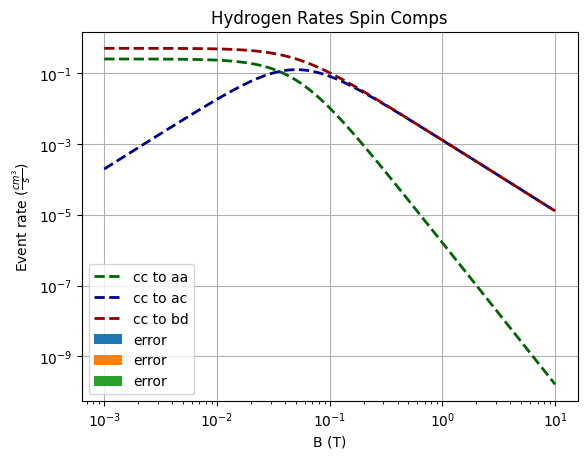

In [26]:
plt.plot(B_Values, HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values, HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values, HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.fill_between(B_Values,np.asarray(HSpinaa,dtype=float) - ucHSpin['a'],np.asarray(HSpinaa,dtype=float) + ucHSpin['a'], label = "error")
plt.fill_between(B_Values,np.asarray(HSpinac,dtype=float) - ucHSpin['c'],np.asarray(HSpinac,dtype=float) + ucHSpin['c'], label = "error")
plt.fill_between(B_Values,np.asarray(HSpinbd,dtype=float) - ucHSpin['d'],np.asarray(HSpinbd,dtype=float) + ucHSpin['d'], label = "error")
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spin Comps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [27]:
print(ucHSpin)

{'a': array([1.39095231e-68, 9.41790624e-69, 6.80987067e-69, 4.85384399e-69,
       3.26004447e-69, 2.17336298e-69, 1.39457458e-69, 1.05045877e-69,
       7.33510005e-70, 4.79950991e-70, 3.44115805e-70, 2.35447656e-70,
       1.65266143e-70, 1.06404229e-70, 7.47093524e-71, 5.20701547e-71,
       3.79206561e-71, 2.54690974e-71, 1.64134183e-71, 1.16025888e-71,
       8.20670917e-72, 5.73054692e-72, 3.74961712e-72, 2.65303098e-72,
       1.80406107e-72, 1.30882862e-72, 8.66656787e-73, 6.19040562e-73,
       4.06798084e-73, 3.05098563e-73, 1.81290450e-73, 1.34862408e-73,
       9.28560843e-74, 6.19040562e-74, 4.36644682e-74, 3.15047429e-74,
       2.21085915e-74, 1.40942271e-74, 1.02252236e-74, 6.90893484e-75,
       4.69807569e-75, 3.52355677e-75, 2.38358252e-75, 1.55451034e-75,
       1.08815724e-75, 7.85891339e-76, 5.44078619e-76, 3.49764826e-76,
       2.50448888e-76, 1.68405287e-76, 1.18747318e-76, 7.77255170e-77,
       5.82941377e-77, 3.83229980e-77, 2.53687451e-77, 1.78120976e-77,


In [28]:
HSpatials = GetSpatials(Hmu, B_Values, HLevels, Silvera_Triplet, singletcombo)
TSpatials = GetSpatials(Tmu, B_Values, TLevels, Silvera_Triplet, singletcombo)

In [29]:
for k in ['a','b','c','d']:                       
    ucHLevels[k] = np.asarray(ucHLevels[k], dtype=float) / np.sqrt(12)
    
def bump_HLevels(sign=+1):
    return {k: np.asarray(HLevels[k], dtype=float) + sign*ucHLevels[k]for k in HLevels}

In [30]:
ucHSpatials = [0,1,2]
for i in [0,1,2]:
    cHmu = 1/2 * (GetSpatials(Hmu+uHmu / np.sqrt(12),B_Values, HLevels, Silvera_Triplet, singletcombo)[i] - GetSpatials(Hmu-uHmu / np.sqrt(12),B_Values, HLevels, Silvera_Triplet, singletcombo)[i])
    cHLevels = 1/2 * (GetSpatials(Hmu,B_Values, bump_HLevels(+1), Silvera_Triplet, singletcombo)[i] - GetSpatials(Hmu,B_Values, bump_HLevels(-1), Silvera_Triplet, singletcombo)[i])
    cHPont = 1/2 * (GetSpatials(Hmu, B_Values, HLevels,pucSilvera_Triplet, singletcombo)[i] - GetSpatials(Hmu, B_Values,HLevels, nucSilvera_Triplet, singletcombo)[i])
    ucHSpatials[i] = np.sqrt(cHmu**2 + cHLevels**2 + cHPont**2)

In [31]:
print(ucHSpatials)

[array([8.14462901e-13, 8.14476301e-13, 8.14492440e-13, 8.14511878e-13,
       8.14535289e-13, 8.14563483e-13, 8.14597438e-13, 8.14638328e-13,
       8.14687569e-13, 8.14746863e-13, 8.14818258e-13, 8.14904218e-13,
       8.15007705e-13, 8.15132282e-13, 8.15282227e-13, 8.15462679e-13,
       8.15679808e-13, 8.15941011e-13, 8.16255156e-13, 8.16632858e-13,
       8.17086809e-13, 8.17632161e-13, 8.18286972e-13, 8.19072716e-13,
       8.20014864e-13, 8.21143532e-13, 8.22494200e-13, 8.24108479e-13,
       8.26034912e-13, 8.28329769e-13, 8.31057788e-13, 8.34292776e-13,
       8.38117980e-13, 8.42626095e-13, 8.47918778e-13, 8.54105493e-13,
       8.61301568e-13, 8.69625337e-13, 8.79194343e-13, 8.90094908e-13,
       9.02477846e-13, 9.16403887e-13, 9.31935718e-13, 9.49108932e-13,
       9.67807951e-13, 9.88229961e-13, 1.01022436e-12, 1.03365270e-12,
       1.05839868e-12, 1.08485511e-12, 1.11120527e-12, 1.13885228e-12,
       1.16702018e-12, 1.19666475e-12, 1.22504492e-12, 1.25296397e-12,
     

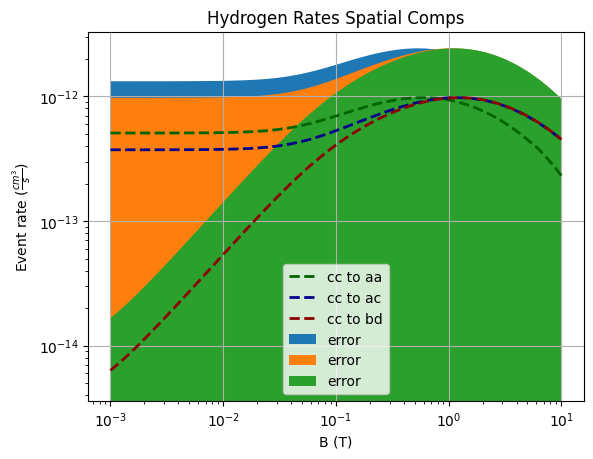

In [32]:
plt.plot(B_Values,HSpatials[0],  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpatials[1],  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpatials[2],  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.fill_between(B_Values,np.asarray(HSpatials[0],dtype=float) - ucHSpatials[0],np.asarray(HSpatials[0],dtype=float) + ucHSpatials[0], label = "error")
plt.fill_between(B_Values,np.asarray(HSpatials[1],dtype=float) - ucHSpatials[1],np.asarray(HSpatials[1],dtype=float) + ucHSpatials[1], label = "error")
plt.fill_between(B_Values,np.asarray(HSpatials[2],dtype=float) - ucHSpatials[2],np.asarray(HSpatials[2],dtype=float) + ucHSpatials[2], label = "error")
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spatial Comps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [33]:
uncert = [0,1,2]

uSpatial = np.asarray(ucHSpatials[0], dtype=float)
Spatial  = np.asarray(HSpatials[0],  dtype=float)
uSpin    = np.asarray(ucHSpin['a'],    dtype=float)
Spin     = np.asarray(HSpinaa,     dtype=float)

frac_unc = np.sqrt((uSpatial / Spatial)**2 + (uSpin / Spin)**2)
uncert[0] = frac_unc * Spatial * Spin

uSpatial = np.asarray(ucHSpatials[1], dtype=float)
Spatial  = np.asarray(HSpatials[1],  dtype=float)
uSpin    = np.asarray(ucHSpin['c'],    dtype=float)
Spin     = np.asarray(HSpinac,     dtype=float)

frac_unc = np.sqrt((uSpatial / Spatial)**2 + (uSpin / Spin)**2)
uncert[1] = frac_unc * Spatial * Spin

uSpatial = np.asarray(ucHSpatials[2], dtype=float)
Spatial  = np.asarray(HSpatials[2],  dtype=float)
uSpin    = np.asarray(ucHSpin['d'],    dtype=float)
Spin     = np.asarray(HSpinbd,     dtype=float)

frac_unc = np.sqrt((uSpatial / Spatial)**2 + (uSpin / Spin)**2)
uncert[2] = frac_unc * Spatial * Spin


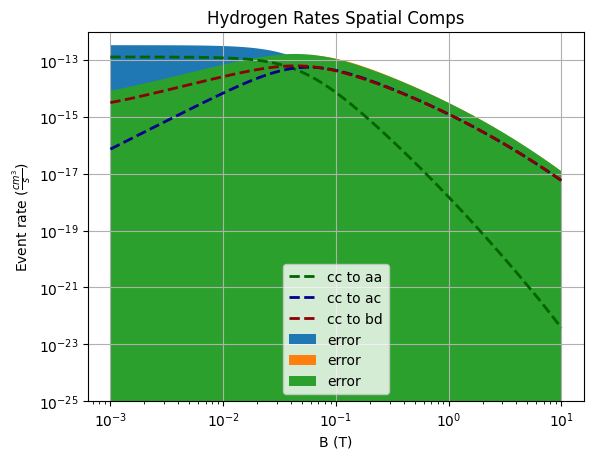

In [48]:
plt.plot(B_Values,HSpatials[0]*HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpatials[1]*HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpatials[2]*HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.fill_between(B_Values,np.asarray(HSpatials[0]*HSpinaa,dtype=float) - uncert[0],np.asarray(HSpatials[0]*HSpinaa,dtype=float) + uncert[0], label = "error")
plt.fill_between(B_Values,np.asarray(HSpatials[1]*HSpinac,dtype=float) - uncert[1],np.asarray(HSpatials[1]*HSpinac,dtype=float) + uncert[1], label = "error")
plt.fill_between(B_Values,np.asarray(HSpatials[2]*HSpinbd,dtype=float) - uncert[2],np.asarray(HSpatials[2]*HSpinbd,dtype=float) + uncert[2], label = "error")
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spatial Comps")
plt.grid(True)
plt.ylim(1e-25,1e-12)
plt.legend()
plt.loglog()
plt.show()

In [46]:
print(np.asarray(HSpatials[0]*HSpinaa,dtype=float))
print(uncert[0])

[1.26974707e-13 1.26956553e-13 1.26934691e-13 1.26908367e-13
 1.26876671e-13 1.26838509e-13 1.26792566e-13 1.26737263e-13
 1.26670699e-13 1.26590595e-13 1.26494214e-13 1.26378274e-13
 1.26238843e-13 1.26071215e-13 1.25869766e-13 1.25627783e-13
 1.25337273e-13 1.24988738e-13 1.24570922e-13 1.24070538e-13
 1.23471960e-13 1.22756912e-13 1.21904147e-13 1.20889157e-13
 1.19683939e-13 1.18256877e-13 1.16572805e-13 1.14593340e-13
 1.12277619e-13 1.09583547e-13 1.06469716e-13 1.02898099e-13
 9.88375943e-14 9.42683667e-14 8.91867645e-14 8.36103534e-14
 7.75823510e-14 7.11745172e-14 6.44874745e-14 5.76485534e-14
 5.08008561e-14 4.40991379e-14 3.76928762e-14 3.17145635e-14
 2.62625822e-14 2.14200946e-14 1.72117998e-14 1.36353015e-14
 1.06588981e-14 8.23284990e-15 6.28110689e-15 4.74484300e-15
 3.55076562e-15 2.63476113e-15 1.94019575e-15 1.41900259e-15
 1.03144516e-15 7.46586248e-16 5.36685010e-16 3.84235364e-16
 2.73813683e-16 1.94328566e-16 1.37470164e-16 9.69378647e-17
 6.80900531e-17 4.766974

In [43]:
print(np.asarray(HSpatials[1]*HSpinac,dtype=float) - uncert[1])

[-4.48123437e-17 -5.39689370e-17 -6.49946222e-17 -7.82700754e-17
 -9.42531211e-17 -1.13494193e-16 -1.36654819e-16 -1.64529676e-16
 -1.98072867e-16 -2.38429137e-16 -2.86970870e-16 -3.45341749e-16
 -4.15508079e-16 -4.99818768e-16 -6.01074940e-16 -7.22610020e-16
 -8.68380820e-16 -1.04306962e-15 -1.25219628e-15 -1.50223812e-15
 -1.80075288e-15 -2.15649735e-15 -2.57952947e-15 -3.08127607e-15
 -3.67454048e-15 -4.37341449e-15 -5.19304804e-15 -6.14921760e-15
 -7.25762404e-15 -8.53284468e-15 -9.98687048e-15 -1.16271836e-14
 -1.34543852e-14 -1.54594738e-14 -1.76210118e-14 -1.99025764e-14
 -2.22510662e-14 -2.45965360e-14 -2.68542202e-14 -2.89291711e-14
 -3.07234826e-14 -3.21454362e-14 -3.31192623e-14 -3.35952057e-14
 -3.35493337e-14 -3.29949996e-14 -3.19738537e-14 -3.05514818e-14
 -2.88099838e-14 -2.68373000e-14 -2.47206480e-14 -2.25374538e-14
 -2.03607903e-14 -1.82430249e-14 -1.62263218e-14 -1.43366754e-14
 -1.25926218e-14 -1.10034231e-14 -9.56736333e-15 -8.28373608e-15
 -7.14405319e-15 -6.15585

In [44]:
print(np.asarray(HSpatials[2]*HSpinbd,dtype=float) - uncert[2])

[-1.99210024e-15 -2.13470983e-15 -2.29468398e-15 -2.47359106e-15
 -2.67312186e-15 -2.89510573e-15 -3.14152736e-15 -3.41454390e-15
 -3.71650194e-15 -4.04995414e-15 -4.41767492e-15 -4.82267469e-15
 -5.26821190e-15 -5.75780180e-15 -6.29522052e-15 -6.88450264e-15
 -7.52992967e-15 -8.23600624e-15 -9.00741964e-15 -9.84897755e-15
 -1.07655169e-14 -1.17617760e-14 -1.28422196e-14 -1.40108051e-14
 -1.52706786e-14 -1.66237844e-14 -1.80703785e-14 -1.96084344e-14
 -2.12329405e-14 -2.29350976e-14 -2.47014479e-14 -2.65129905e-14
 -2.83443786e-14 -3.01633319e-14 -3.19304412e-14 -3.35995688e-14
 -3.51191079e-14 -3.64341239e-14 -3.74891356e-14 -3.82325426e-14
 -3.86209309e-14 -3.86234561e-14 -3.82254547e-14 -3.74164312e-14
 -3.62386321e-14 -3.47321596e-14 -3.29299956e-14 -3.09155592e-14
 -2.87478464e-14 -2.64921017e-14 -2.42086410e-14 -2.19509432e-14
 -1.97596337e-14 -1.76696968e-14 -1.57056309e-14 -1.38811415e-14
 -1.22073528e-14 -1.06858592e-14 -9.31305035e-15 -8.08184771e-15
 -6.99237866e-15 -6.02315

In [50]:
HSpatial2s = GetSpatials(Hmu, B_Values, HLevels, Triplet, singletcombo)

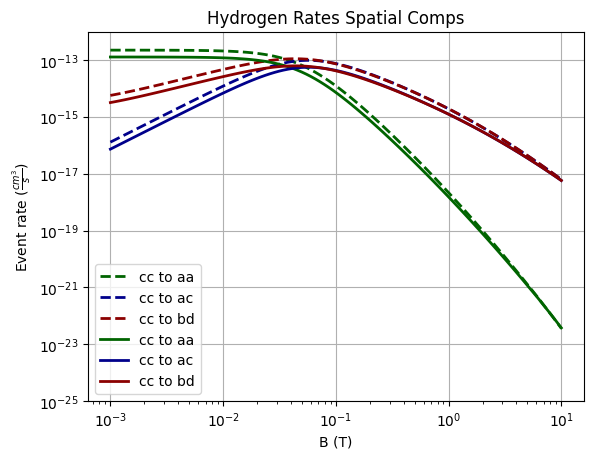

In [52]:
plt.plot(B_Values,HSpatial2s[0]*HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpatial2s[1]*HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpatial2s[2]*HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.plot(B_Values,HSpatials[0]*HSpinaa, label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,HSpatials[1]*HSpinac, label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,HSpatials[2]*HSpinbd, label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spatial Comps")
plt.grid(True)
plt.ylim(1e-25,1e-12)
plt.legend()
plt.loglog()
plt.show()